In [1]:
# nbi:hide_in
##########################
# Created on Mar 2020
# @author: juans
##########################

In [2]:
# nbi:hide_in
# Requried libraries
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive
%matplotlib inline

In [3]:
def dB2mag(x):
    return 10.0**(x / 20.0)

def mag2dB(x):
    return 20.0 * np.log10(np.abs(x))

def dB2pow(x):
    return 10**(x/10.0)

def pow2dB(x):
    return 10 * np.log10(np.abs(x))

In [4]:
# nbi:hide_in
def QuantizeUniform(aNum,nBits):
    #Uniformly quantize signed fraction aNum with nBits
    #Notes:The overload level of the quantizer should be 1.0    
    if(aNum >= 0):
        s = 0
    else:
        s = 1
        
    if(np.abs(aNum) >= 1):
        code = 2**(nBits-1)-1
    else:
        code = int(((2**(nBits)-1)*np.abs(aNum)+1)/2)
        
        
    if(s == 0):
       return int(code)
    else:
       return int(code + 2**(nBits-1))
   
def DequantizeUniform(aQuantizedNum,nBits):
    #Uniformly dequantizes nBits-long number aQuantizedNum 
    #into a signed fraction
    if (aQuantizedNum>>(nBits-1)):
        sign = -1
    else:
        sign = 1
    
    if (sign == -1):
        aNum =  sign*float(2*np.abs(aQuantizedNum - 2**(nBits-1)))/(2**nBits -1)    
    else:
        aNum =  sign*float(2*np.abs(aQuantizedNum))/(2**nBits -1) 

    return aNum

def QuantizeAndDequantizeUniform(aNum, nBits):
    return DequantizeUniform(QuantizeUniform(aNum, nBits), nBits)

def ScaleFactor(aNum, nScaleBits, nMantBits):
    # Return the floating-point scale factor for a  signed 
    # fraction aNum given nScaleBits scale bits and nMantBits mantissa bits  
    #Notes:
    #The scale factor should be the number of leading zeros
    if nScaleBits < 0: nScaleBits = 0
    if nMantBits <= 0: return 0       # 0 mantissa bits returns 0
    
    maxScale=(1 << nScaleBits) - 1    # max leading 0s scale can id
    maxBits = maxScale + nMantBits    # max bits equiv to this FP rep
    signBit = (1 << (maxBits - 1))    # the location of the sign bit in the Uni Q num
    
    # Uniformly quantize magnitue using maxBits and left shift away sign bit
    code = QuantizeUniform(abs(aNum), maxBits)
    code <<= 1
    # get Scale by shifting left till you hit a 1
    scale = 0
    while scale < maxScale and (signBit & code) == 0:
        code <<= 1
        scale += 1
    
    return scale

def MantissaFP(aNum, scale, nScaleBits, nMantBits):
    # Return the floating-point mantissa for a  signed fraction 
    # aNum given nScaleBits scale bits and nMantBits mantissa bits
    if nMantBits <= 0: return 0
    if nScaleBits < 0: nScaleBits = 0
        
    maxScale = (1 << nScaleBits) - 1
    maxBits = maxScale + nMantBits
    signBit = (1 << (nMantBits - 1))
    
    # Extract sign
    sign = 0
    if aNum < 0:
        sign = 1
        aNum *= -1
        
    # Compute unsigned code using maxBits uniform quantization
    code = QuantizeUniform(aNum, maxBits)
    # extract the mantissa: shift left by scale factor and sign (remove leading 0)
    code <<= (scale + 1)
    # remove leading 1 (if we know it is there) and shfit Left on emore time
    if scale < maxScale:
        code -= (1 << (maxBits - 1)) 
        code <<= 1
    # move bits starting at maxBits down to loest nMantBits - 1
    code >>= (maxBits - nMantBits + 1)
    # add sign to the front of the code
    if sign: code += signBit
        
    return code

def DequantizeFP(scale, mantissa, nScaleBits, nMantBits):
    # Returns a signed fraction for floating point scale and mantissa given
    # Specified scale and mantissa bits
    # zero mantissa bits means zero
    if nMantBits <= 0: return 0
    if nScaleBits < 0: nScaleBits = 0
        
    maxScale = (1 << nScaleBits ) - 1
    maxBits = maxScale + nMantBits
    signBit = (1 << (nMantBits - 1))
    
    if mantissa & signBit:
        sign = 1
        mantissa -= signBit
    else:
        sign = 0
    
    if scale < maxScale:
        mantissa = mantissa + (1 << (nMantBits - 1))
        
    if scale < (maxScale - 1):
        mantissa = (mantissa << 1) + 1
        mantissa <<= (maxScale - scale - 2)
        
    if sign:
        signBit = (1 << (maxBits -1))
        mantissa += signBit
    return DequantizeUniform(mantissa, maxBits)

def QuantizeAndDequantizeFP(aNum, nScaleBits, nMantBits):
    scale = ScaleFactor(aNum, nScaleBits, nMantBits)
    mantissa = MantissaFP(aNum, scale, nScaleBits, nMantBits)
    return DequantizeFP(scale, mantissa, nScaleBits, nMantBits)

In [5]:
N = 2**10
n = np.arange(N)
f = 25
xo = np.sin( 2 * np.pi * f * n / N)
y = np.zeros_like(xo)
gainIndB = np.arange(-200, 6, 1)
K = len(gainIndB)
nBits = [8, 16, 24, 32]
Ru = len(nBits)
nScaleBits = [3, 4, 7, 8];
nMantBits = [5, 12, 17, 24];
Rfp = len(nScaleBits)

SNR_Uni = np.zeros([K, Ru])
SNR_FP = np.zeros([K, Rfp])

In [6]:
for i in np.arange(Ru):
    for k in np.arange(K):
        x = dB2mag(gainIndB[k]) * xo
        for n in np.arange(N):
            y[n] = QuantizeAndDequantizeUniform(x[n], nBits[i])
        e = y - x
        SNR_Uni[k, i] = pow2dB(np.mean(x**2) / np.mean(e**2))

In [9]:
for i in np.arange(Rfp):
    for k in np.arange(K):
        x = dB2mag(gainIndB[k]) * xo
        for n in np.arange(N):
            y[n] = QuantizeAndDequantizeFP(x[n], nScaleBits[i], nMantBits[i])
        e = y - x
        SNR_FP[k, i] = pow2dB(np.mean(x**2) / np.mean(e**2))

/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in long_scalars


Text(0.5, 1.0, 'Experimental SNR for Different Formats')

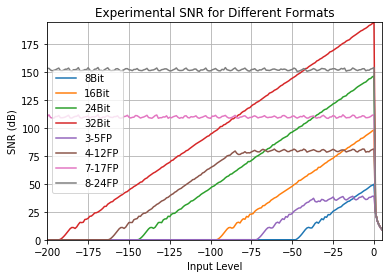

In [8]:
plt.plot(gainIndB, SNR_Uni)
plt.plot(gainIndB, SNR_FP)
plt.legend(["8Bit", "16Bit", "24Bit", "32Bit", "3-5FP", "4-12FP", "7-17FP", "8-24FP"])
plt.grid(True)
plt.autoscale(tight=True)
plt.xlabel("Input Level")
plt.ylabel("SNR (dB)")
plt.title("Experimental SNR for Different Formats")